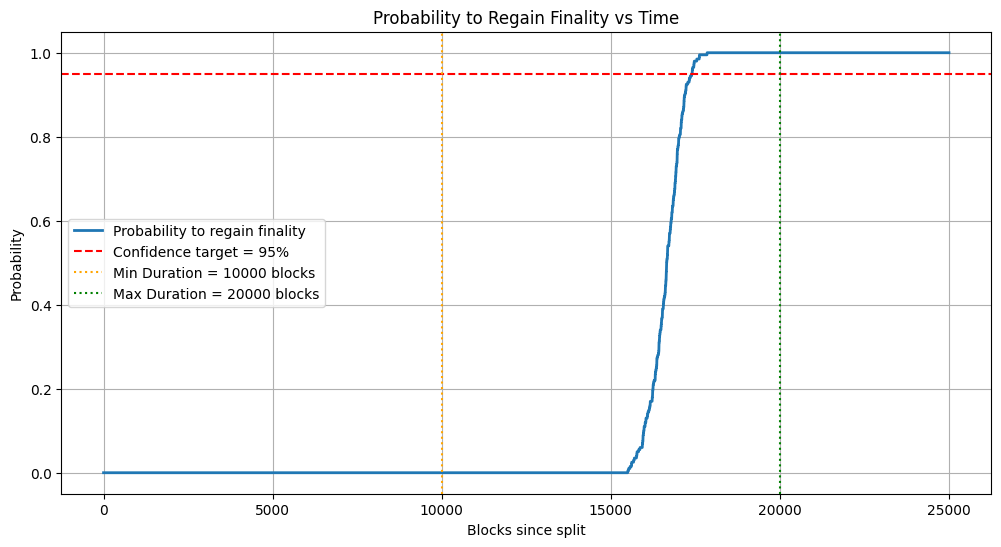

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- PARAMETERS ---
total_generators = 100        # Total number of initial generators
min_duration = 10000           # Minimum commitment duration
max_duration = 20000           # Maximum commitment duration
simulation_time = 25000        # Total simulation time after split
finality_threshold_fraction = 1/3  # Finality threshold (e.g., 33%)
confidence_target = 0.95       # Desired confidence level
num_simulations = 200          # Number of Monte Carlo simulations (adjust for speed)

# --- MONTE CARLO SIMULATION ---
time = np.arange(simulation_time)
intersection_records = np.zeros((num_simulations, simulation_time))

for sim in range(num_simulations):
    # Generate random commitment durations
    commitment_durations = np.random.uniform(min_duration, max_duration, total_generators)
    expiration_times = commitment_durations  # all issued at t=0

    # Compute intersection size over time using cumulative histogram
    counts, _ = np.histogram(expiration_times, bins=np.append(time, simulation_time))
    intersection = total_generators - np.cumsum(counts)
    intersection_records[sim] = intersection

# --- PROBABILITY COMPUTATION ---
finality_threshold = finality_threshold_fraction * total_generators
prob_finality_restored = np.mean(intersection_records <= finality_threshold, axis=0)

# --- PLOT ---
plt.figure(figsize=(12, 6))
plt.plot(time, prob_finality_restored, label="Probability to regain finality", linewidth=2)
plt.axhline(confidence_target, color='red', linestyle='--', label=f"Confidence target = {confidence_target*100:.0f}%")
plt.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration = {min_duration} blocks")
plt.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration = {max_duration} blocks")
plt.xlabel("Blocks since split")
plt.ylabel("Probability")
plt.title("Probability to Regain Finality vs Time")
plt.legend()
plt.grid(True)
plt.show()

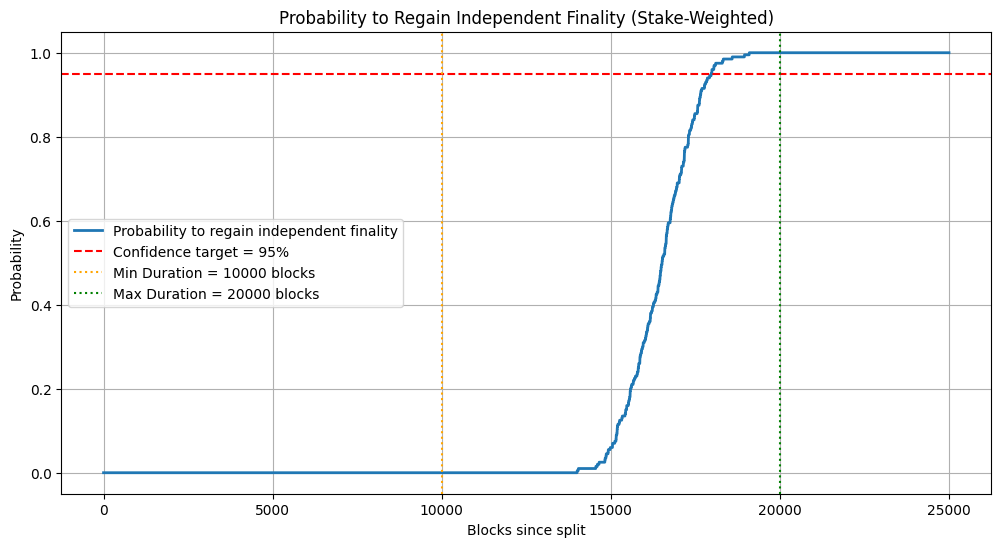

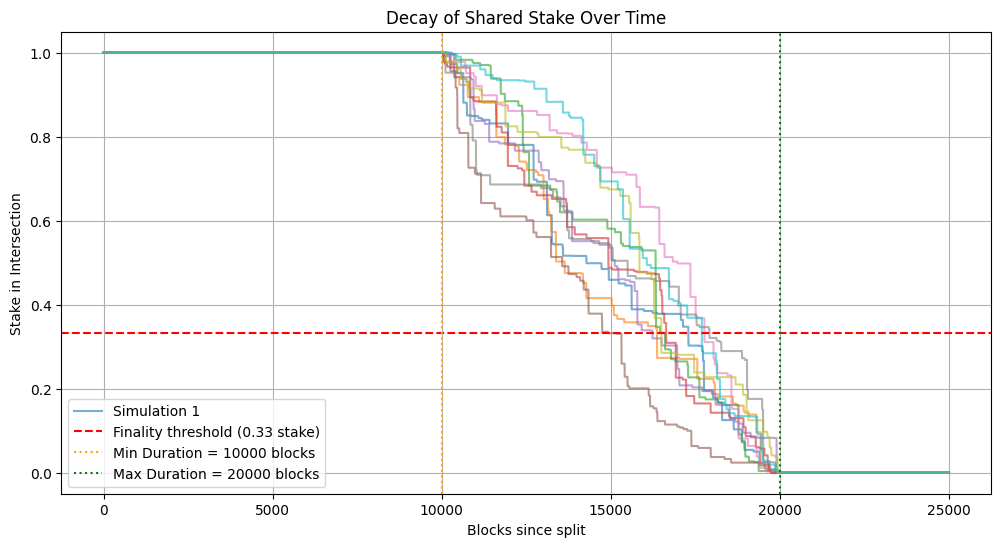

In [6]:
# Stake-Weighted Finality Recovery Model for Network Split
# --------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# CONFIGURABLE PARAMETERS
# ------------------------------

total_generators = 50            # Total number of initial generators
min_duration = 10000               # Minimum commitment duration (blocks)
max_duration = 20000               # Maximum commitment duration (blocks)
simulation_time = 25000            # How many blocks to simulate after split
finality_fraction = 2 / 3          # Waves-style finality threshold (e.g., 2/3)
confidence_target = 0.95           # Required probability to accept finality recovery
num_simulations = 200              # Number of Monte Carlo simulations

# ------------------------------
# GENERATOR STAKES
# ------------------------------

# Generate random stake distribution (exponential, can be adjusted)
np.random.seed(42)  # For reproducibility
stakes = np.random.exponential(scale=1.0, size=total_generators)
stakes /= stakes.sum()  # Normalize so total stake = 1.0

# ------------------------------
# MONTE CARLO SIMULATION
# ------------------------------

time = np.arange(simulation_time)
intersection_stake_records = np.zeros((num_simulations, simulation_time))

for sim in range(num_simulations):
    # Each generator picks a commitment duration
    commitment_durations = np.random.uniform(min_duration, max_duration, total_generators)
    expiration_times = commitment_durations  # Commitments issued at split (t=0)

    # For each block, sum stake of active generators
    intersection_stake = []
    for t in time:
        active = expiration_times >= t
        intersection_stake.append(stakes[active].sum())
    intersection_stake_records[sim] = intersection_stake

# ------------------------------
# FINALITY THRESHOLD
# ------------------------------

finality_threshold_stake = 1 - finality_fraction  # e.g., 1 - 2/3 = 1/3

# Compute probability to regain finality at each block height
prob_finality_restored_stake = np.mean(intersection_stake_records <= finality_threshold_stake, axis=0)

# ------------------------------
# PLOT 1: Probability of Independent Finality Recovery
# ------------------------------

plt.figure(figsize=(12, 6))
plt.plot(time, prob_finality_restored_stake, label="Probability to regain independent finality", linewidth=2)
plt.axhline(confidence_target, color='red', linestyle='--', label=f"Confidence target = {confidence_target * 100:.0f}%")
plt.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration = {min_duration} blocks")
plt.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration = {max_duration} blocks")
plt.xlabel("Blocks since split")
plt.ylabel("Probability")
plt.title("Probability to Regain Independent Finality (Stake-Weighted)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# PLOT 2: Shared Stake Decay Over Time
# ------------------------------

plt.figure(figsize=(12, 6))

# Plot several sample simulations
for i in range(min(10, num_simulations)):
    plt.plot(time, intersection_stake_records[i], alpha=0.6, label=f"Simulation {i+1}" if i < 1 else "")

plt.axhline(finality_threshold_stake, color='red', linestyle='--', label=f"Finality threshold ({finality_threshold_stake:.2f} stake)")
plt.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration = {min_duration} blocks")
plt.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration = {max_duration} blocks")
plt.xlabel("Blocks since split")
plt.ylabel("Stake in Intersection")
plt.title("Decay of Shared Stake Over Time")
plt.legend()
plt.grid(True)
plt.show()

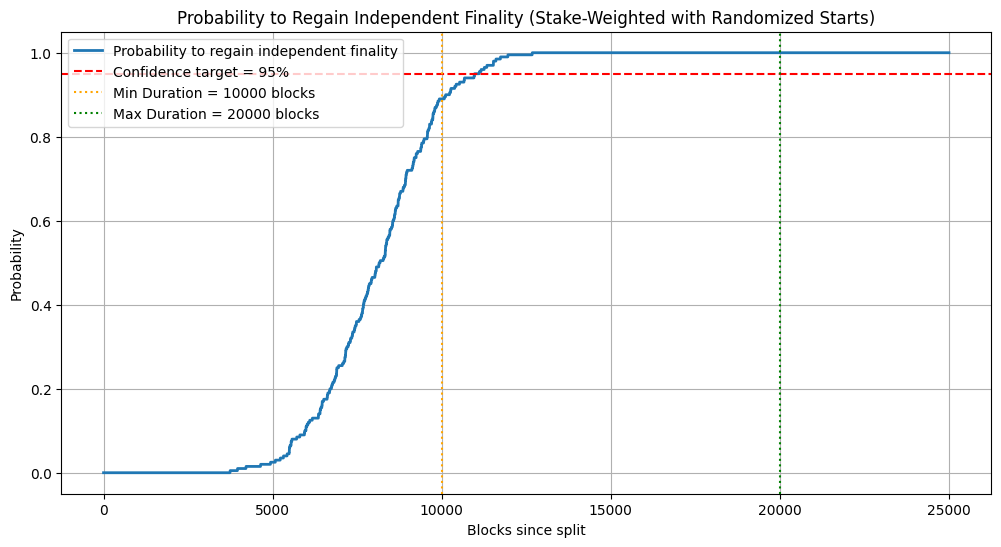

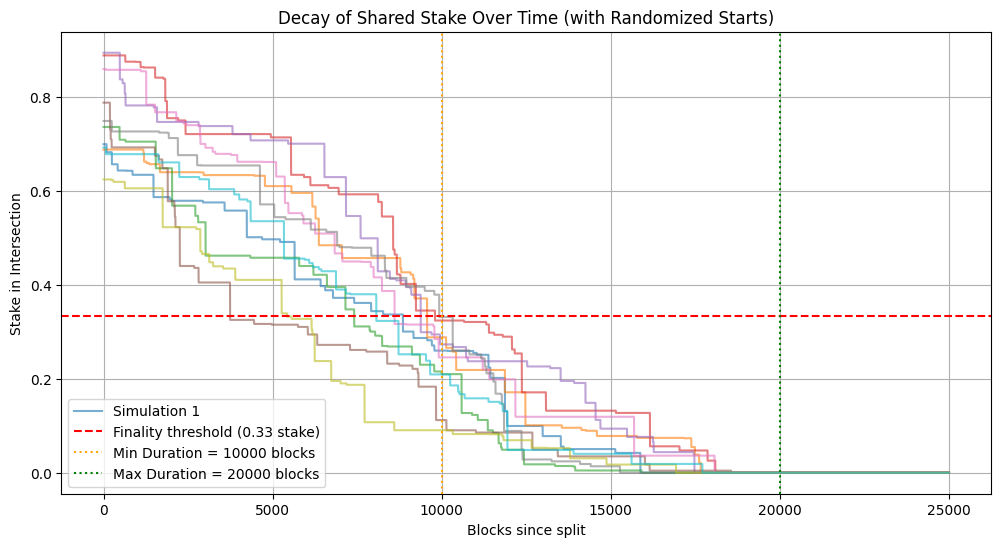

In [8]:
# Stake-Weighted Finality Recovery Model with Randomized Commitment Starts
# -----------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# CONFIGURABLE PARAMETERS
# ------------------------------

total_generators = 50            # Total number of initial generators
min_duration = 10000               # Minimum commitment duration (blocks)
max_duration = 20000               # Maximum commitment duration (blocks)
simulation_time = 25000            # How many blocks to simulate after split

finality_fraction = 2 / 3          # Waves-style finality threshold (e.g., 2/3)
confidence_target = 0.95           # Required probability to accept finality recovery
num_simulations = 200              # Number of Monte Carlo simulations

# ------------------------------
# GENERATOR STAKES
# ------------------------------

# Generate random stake distribution
np.random.seed(42)  # For reproducibility
stakes = np.random.exponential(scale=1.0, size=total_generators)
stakes /= stakes.sum()  # Normalize so total stake = 1.0

# ------------------------------
# MONTE CARLO SIMULATION with RANDOM COMMITMENT STARTS
# ------------------------------

time = np.arange(simulation_time)
intersection_stake_records = np.zeros((num_simulations, simulation_time))

for sim in range(num_simulations):
    # Sample random commitment start times uniformly from [-max_duration, 0]
    start_times = np.random.uniform(-max_duration, 0, total_generators)
    # Sample random durations
    commitment_durations = np.random.uniform(min_duration, max_duration, total_generators)
    # Compute expiration times
    expiration_times = start_times + commitment_durations  # this is now relative to t=0 (split)

    # For each block, sum stake of active generators
    intersection_stake = []
    for t in time:
        active = expiration_times >= t
        intersection_stake.append(stakes[active].sum())
    intersection_stake_records[sim] = intersection_stake

# ------------------------------
# FINALITY THRESHOLD
# ------------------------------

finality_threshold_stake = 1 - finality_fraction  # e.g., 1 - 2/3 = 1/3

# Compute probability to regain finality at each block height
prob_finality_restored_stake = np.mean(intersection_stake_records <= finality_threshold_stake, axis=0)

# ------------------------------
# PLOT 1: Probability of Independent Finality Recovery
# ------------------------------

plt.figure(figsize=(12, 6))
plt.plot(time, prob_finality_restored_stake, label="Probability to regain independent finality", linewidth=2)
plt.axhline(confidence_target, color='red', linestyle='--', label=f"Confidence target = {confidence_target * 100:.0f}%")
plt.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration = {min_duration} blocks")
plt.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration = {max_duration} blocks")
plt.xlabel("Blocks since split")
plt.ylabel("Probability")
plt.title("Probability to Regain Independent Finality (Stake-Weighted with Randomized Starts)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# PLOT 2: Stake Intersection Decay Over Time
# ------------------------------

plt.figure(figsize=(12, 6))

# Plot several sample simulations
for i in range(min(10, num_simulations)):
    plt.plot(time, intersection_stake_records[i], alpha=0.6, label=f"Simulation {i+1}" if i < 1 else "")

plt.axhline(finality_threshold_stake, color='red', linestyle='--', label=f"Finality threshold ({finality_threshold_stake:.2f} stake)")
plt.axvline(min_duration, color='orange', linestyle=':', label=f"Min Duration = {min_duration} blocks")
plt.axvline(max_duration, color='green', linestyle=':', label=f"Max Duration = {max_duration} blocks")
plt.xlabel("Blocks since split")
plt.ylabel("Stake in Intersection")
plt.title("Decay of Shared Stake Over Time (with Randomized Starts)")
plt.legend()
plt.grid(True)
plt.show()